**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# imports and sets magics
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import minimize_scalar, fsolve
from scipy import interpolate
from ipywidgets import interact

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [2]:
# creating symbols
C = sm.symbols('C') 
k = sm.symbols('kappa')
w = sm.symbols('omega')
t = sm.symbols('tau')
G = sm.symbols('G')
v = sm.symbols('nu')
L = sm.symbols('L')
a = sm.symbols('alpha')
w_tilde = sm.symbols('omegatilde')
L_star = sm.symbols('L^*')

In [3]:
# defining the utility function in symbols
utility = sm.log(C**a*G**(1-a))-v*(L**2)/2
utility

-L**2*nu/2 + log(C**alpha*G**(1 - alpha))

In [4]:
# defining the consumption constraint as an equality in symbols
consumption_constraint = sm.Eq(k+w_tilde*L,C)
consumption_constraint

Eq(L*omegatilde + kappa, C)

In [5]:
# isolating C in the consumption constraint
C_from_constraint = sm.solve(consumption_constraint,C)
C_from_constraint[0]

L*omegatilde + kappa

In [6]:
# substituting C from the consumption constraint into the utility function
utility_subs = utility.subs(C,C_from_constraint[0])
utility_subs

-L**2*nu/2 + log(G**(1 - alpha)*(L*omegatilde + kappa)**alpha)

In [7]:
# calculating the first order condition wrt. L
foc = sm.diff(utility_subs, L)
foc

G**(1 - alpha)*G**(alpha - 1)*alpha*omegatilde/(L*omegatilde + kappa) - L*nu

In [8]:
# solving an equation for optimal labour supply
sol = sm.solve(sm.Eq(foc,0), L)[1] # Since the results is symmetric, we choose the second element to get the positive solution
sol_opt = sm.Eq(L_star,sol)
sol_opt

Eq(L^*, (-kappa*nu + sqrt(nu*(4*alpha*omegatilde**2 + kappa**2*nu)))/(2*nu*omegatilde))

This can be re-written to the given expression from the question.
$$L^{\star}(\tilde{w})=\frac{- \kappa \nu + \sqrt{\nu \left(4 \alpha \tilde{\omega}^{2} + \kappa^{2} \nu\right)}}{2 \nu \tilde{\omega}}=\frac{- \kappa + \frac{\sqrt{4 \alpha \tilde{\omega}^{2} + \kappa^{2} \nu}}{\sqrt{\nu}}}{2 \tilde{\omega}} = \frac{- \kappa + \sqrt{\frac{4 \alpha \tilde{\omega}^{2} + \kappa^{2} \nu}{\nu}}}{2 \tilde{\omega}}=\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}},$$

where $\tilde{w} = (1-\tau)w$.

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

Mathematically:
We insert the equation for $\tilde{\omega}$ into the optimal solution for L 

In [9]:
# defining w_tilde
w_tilde_eq = (1-t)*w

#substituting the expression for w_tilde into the optimal labour supply
L_star_subs = sol.subs(w_tilde,w_tilde_eq)
L_star_subs_opt = sm.Eq(L_star, L_star_subs)
L_star_subs_opt


Eq(L^*, (-kappa*nu + sqrt(nu*(4*alpha*omega**2*(1 - tau)**2 + kappa**2*nu)))/(2*nu*omega*(1 - tau)))

Illustration:

In [10]:
# we lambdify the labour supply equation
labour_supply_function = sm.lambdify((w,v,k,a,t),L_star_subs)

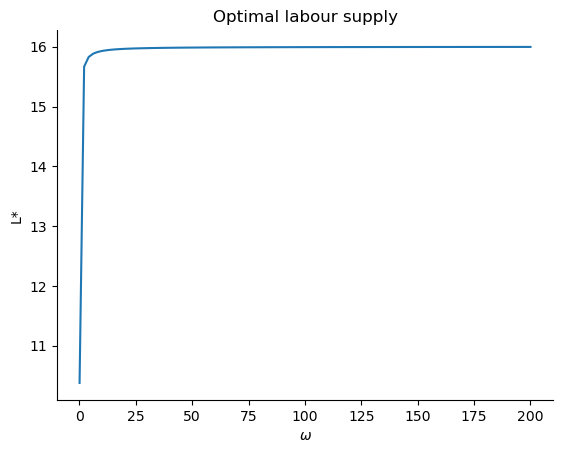

In [11]:
#creating a vector of omega-values
w_vec = np.linspace(0.1,200,100)

# adding value to parameters
a_val = 0.5
k_val = 1
v_val = 1/(2*16**2)
w_val = 1
t_val = 0.3

# find optimal labour supply given a vector of omega-values
labour_supply_vec = labour_supply_function(w_vec,v_val, k_val, a_val, t_val)

# plot optimal labour supply given omega
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(w_vec,labour_supply_vec)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel(r"$\omega$")
plt.ylabel("L*")
plt.title("Optimal labour supply");

We see that optimal labour supply is positive and concave increasing in $\omega$. The optimal labour supply is increasing in the wage $\omega$ up to a certain point around 16 hours of work pr. day, afterwhich the effect of an increasing wage is declining, showing deminishing returns to labour. 


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


Using our optimal solution $L^*$ from question 1.2 we find the corresponding G and U and plot these against a vector of $\tau$

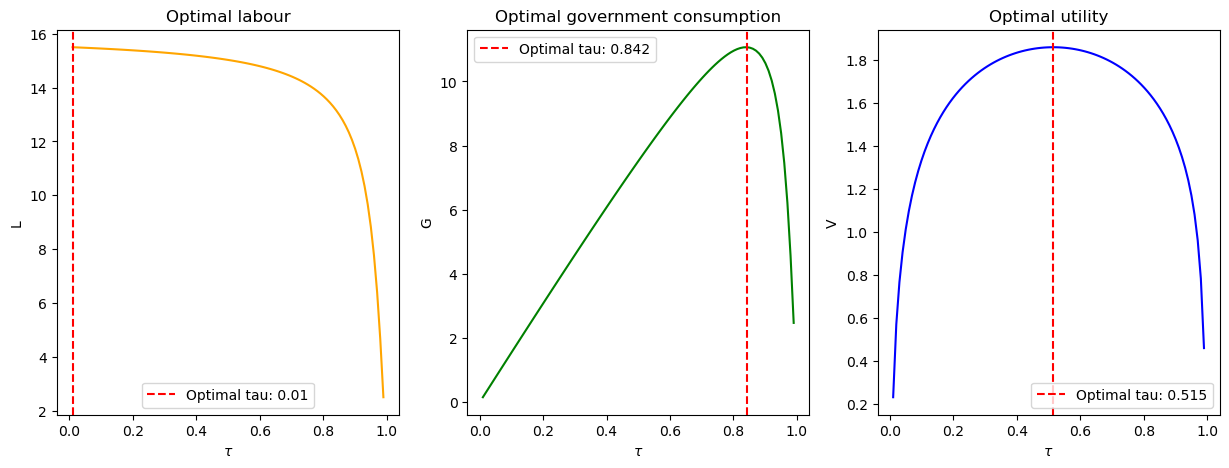

In [12]:
# creating vector of tau-values
t_vec = np.linspace(0.01,0.99,100)

# find optimal labour supply, government spending and utility given tau
optimal_L = labour_supply_function(w_val,v_val, k_val, a_val, t_vec)

optimal_G = t_vec*w_val*optimal_L

optimal_V = np.log((k_val+(1-t_vec)*w_val*optimal_L)**a_val*optimal_G**(1-a_val))-v_val*optimal_L**2/2

# find tau values that maximises labour supply, government spending and utility
opt_L_val = t_vec[np.argmax(optimal_L)]
opt_G_val = t_vec[np.argmax(optimal_G)]
opt_t_val = t_vec[np.argmax(optimal_V)]

# plotting
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,3,1)
ax.plot(t_vec,optimal_L, c="orange")
plt.xlabel(r"$\tau$")
plt.ylabel("L")
plt.title("Optimal labour")
plt.axvline(x=opt_L_val, color='r', linestyle='--', label=f"Optimal tau: {opt_L_val:.2f}")
plt.legend()

ax = fig.add_subplot(1,3,2)
ax.plot(t_vec,optimal_G, c="green")
plt.xlabel(r"$\tau$")
plt.ylabel("G")
plt.title("Optimal government consumption")
plt.axvline(x=opt_G_val, color='r', linestyle='--', label=f"Optimal tau: {opt_G_val:.3f}")
plt.legend()

ax = fig.add_subplot(1,3,3)
ax.plot(t_vec,optimal_V,  c="blue")
plt.xlabel(r"$\tau$")
plt.ylabel("V")
plt.title("Optimal utility")
plt.axvline(x=opt_t_val, color='r', linestyle='--', label=f"Optimal tau: {opt_t_val:.3f}")
plt.legend();


We note that:
*   Labour is concavely decreasing in $\tau$, as income per labour input decreases when the income tax increases.
*   Optimal government consumption increases with tax income up to a certain point whereafter it decreases, because of the negative behavioural effect of workers substituting away from labour. This is known as the Laffer curve.
*   Optimal utility depends on both labour and government consumption which have an inverse relationsship as $\tau$ increases. Thus utility is shaped like an upside down parabola with a maximum.

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

We find the optimal tax rate, inserting L* in the government consumption function which finally is inserted into the utility function:


In [13]:
# defining utility function
def utility_function(tau, L):
    V = np.log((k_val + (1 - tau) * w_val * L)**a_val * (tau*w_val*(labour_supply_function(w_val,v_val, k_val, a_val, tau)))**(1 - a_val)) - v_val * L**2 / 2
    return V

# definin>g objective function
obj_func = lambda x: -utility_function(x[0], x[1])

# defining bounds for tau and L
bound = [(0.1, 0.9), (0, 24)]

# defining guesses for tau and L
x0 = [0.4, 16]

# calling optimizer
result = optimize.minimize(obj_func, x0, method='SLSQP', bounds=bound, options={'disp': True})

# defining the results
tau_opt = result.x[0]
L_opt = result.x[1]

# printing results
print('\n tau =', tau_opt)
print('\n L =', L_opt)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.8591992399584583
            Iterations: 12
            Function evaluations: 37
            Gradient evaluations: 12

 tau = 0.5145207498408622

 L = 15.00078049014353


We get that the socially optimal taxation $\tau^*= 0.515$ and the optimal labour hours are $L^*=15$

We illustrate labour and utility given the optimal tax rate:

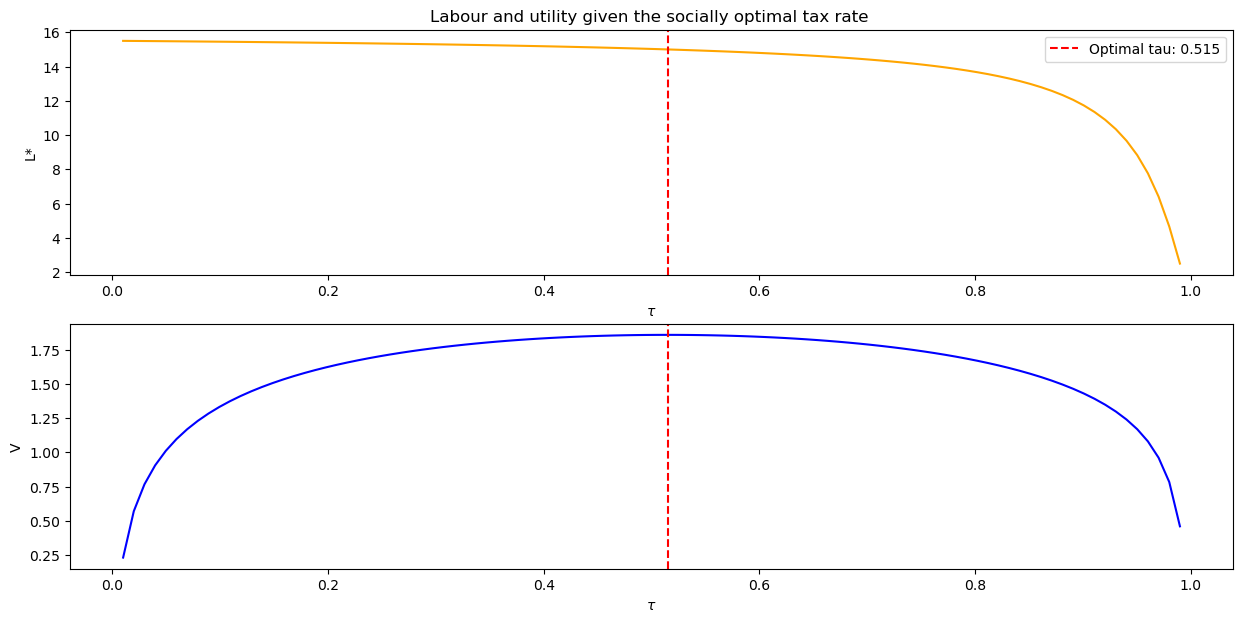

In [14]:
# plotting
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(2,1,1)
ax.plot(t_vec,optimal_L, c="orange")
plt.xlabel(r"$\tau$")
plt.ylabel("L*")
plt.title("Labour and utility given the socially optimal tax rate ")
plt.axvline(x=opt_t_val, color='r', linestyle='--', label=f"Optimal tau: {opt_t_val:.3f}")
plt.legend()

ax = fig.add_subplot(2,1,2)
ax.plot(t_vec,optimal_V,  c="blue")
plt.xlabel(r"$\tau$")
plt.ylabel("V")
plt.axvline(x=opt_t_val, color='r', linestyle='--', label=f"Optimal tau: {opt_t_val:.3f}");

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.
Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.



**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

We use the interpolation method to solve the dynamic optimization problem looping over the parameters of set 1 and set 2. 

In [15]:
#defining our optimal tau
t_val_opt = tau_opt

In [16]:
# defining a list of dictionaries for our paramter values in both sets
parameter_sets = [{'sigma_val': 1.001, 'rho_val': 1.001, 'epsilon_val': 1.0},
    {'sigma_val': 1.5, 'rho_val': 1.5, 'epsilon_val': 1.0}]


 # looping over our two sets of parameter values
for i, par in enumerate(parameter_sets):
    print("Results for set", i+1)
    sigma_val = par['sigma_val']
    rho_val = par['rho_val']
    epsilon_val = par['epsilon_val']

    # defining the new utility function
    def utility_function(L):
        V = (((a_val * (k_val+(1-t_val_opt)*w_val*L)**((sigma_val - 1) / sigma_val) + (1 - a_val) * G**((sigma_val - 1) / sigma_val))**(sigma_val / (sigma_val - 1)))**(1 - rho_val) - 1) / (1 - rho_val) - v_val * L**(1 + epsilon_val) / (1 + epsilon_val)
        return V

    # defining the objective function for maximization problem
    def obj_func(L):
        return -utility_function(L)

    # solving for L star
    def solve_utility():
        result = minimize_scalar(obj_func, bounds=(0, 24), method='bounded')
        return result.x

    # defining the equation for G
    def G_eq(G):
        L_star = solve_utility()
        return G - t_val_opt * w_val * L_star
        
    # creating vectors for G, L and utility
    G_vec = np.linspace(0, 10, 101)
    L_vec = np.linspace(0, 1, 101)  
    utility_vec = np.zeros((len(G_vec), len(L_vec)))

    # looping over G and L to fill out the utility vector
    for i, G in enumerate(G_vec):
        for j, L in enumerate(L_vec):
            utility_vec[i, j] = utility_function(L)

    # creating the interpolar
    interp = interpolate.RegularGridInterpolator([G_vec, L_vec], utility_vec, bounds_error=False, fill_value=None)

    # we solve for G*
    G_star = fsolve(G_eq, 1.0)

    # saving the L* solution
    L_star = solve_utility()

    # filling the optimal utility function
    utility_vec = interp([G_star[0], L_star])

    # printing the results
    print(f"G* = {G_star[0]:.3f} \nL* = {L_star:.3f} \nV* = {utility_vec[0]:.3f}\n")

Results for set 1
G* = 7.710 
L* = 14.985 
V* = 3.475

Results for set 2
G* = 4.225 
L* = 8.212 
V* = 1.353



**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

We insert the solution for $L^*$ from question 5 in the utility function and solve for $\tau$. This is done in a loop for each set of parameters. 

In [17]:
for i, par in enumerate(parameter_sets):
    print("\n Results for set", i+1)
    sigma_val = par['sigma_val']
    rho_val = par['rho_val']
    epsilon_val = par['epsilon_val']

    lstar = solve_utility()

    def utility_q6(tau,L):
        V = (((a_val * (k_val+(1-tau)*w_val*L)**((sigma_val - 1) / sigma_val) + (1 - a_val) * (tau*w_val*lstar)**((sigma_val - 1) / sigma_val))**(sigma_val / (sigma_val - 1)))**(1 - rho_val) - 1) / (1 - rho_val) - (v_val * L **(1 + epsilon_val) / (1 + epsilon_val))
        return V

    # defining the objective function
    obj_funcq6 = lambda x: -utility_q6(x[0],x[1])

    # defining bounds for tau and L
    bound = [(0.1, 0.9),(0,24)]

    # guessing on values for tau and L
    x0 = [0.5,16]

    # calling the optimizer 
    resultq6 = optimize.minimize(obj_funcq6, x0, method='SLSQP', bounds=bound, options={'disp': True})

    # defining the results 
    tau_star = resultq6.x[0]
    lst = resultq6.x[1]

    # printing the results 
    print('\n tau* =', tau_star)
    print('\n L* =', lst)



 Results for set 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.8570546482519712
            Iterations: 7
            Function evaluations: 22
            Gradient evaluations: 7

 tau* = 0.5333991591644573

 L* = 14.937694756080502

 Results for set 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0075901252056694
            Iterations: 11
            Function evaluations: 33
            Gradient evaluations: 11

 tau* = 0.523666960183978

 L* = 9.96082893882496


The socially optimal tax $\tau^*$ decreases a small bit going from set 1 of parameters to set 2. Furtermore, we see the optimal labour hours decreasing with the second set of parameters.  

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$
Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

We verify the expression for $\ell_{t}$ mathematically using sympy:

In [18]:
# defining parameters
kappa = sm.symbols('kappa_t') 
n = sm.symbols('eta')
l = sm.symbols('l_t')
w = sm.symbols('omega')
l_star = sm.symbols('l^*')

# defining profit function
pi = kappa*l**(1-n)-w*l

# calculating foc
foc = sm.diff(pi, l)

# maximising profit
sol = sm.solve(sm.Eq(foc,0), l)[0]
sol_opt = sm.Eq(l_star,sol)
sol_opt

Eq(l^*, (kappa_t*(1 - eta)/omega)**(1/eta))

Then we illustrate it graphically in a widget figure altering the value of $\kappa$.

In [19]:
# defining baseline parameters
eta = 0.5 
w = 1.0  

# defining l values
l_values = np.linspace(0, 5, 100) 

def plot_profit(kappa):
    # calculating profit for given value of kappa
    profit = kappa * (l_values**(1-eta)) - w*l_values

    # finding optimal profit
    opt_l = ((1-eta) * kappa/w) ** (1/eta) # calculate optimal l given in question
    max_profit = np.max(profit) # calculate max profit
    max_profit_point = (opt_l, max_profit) # define maximum profit as point

    # plotting profit as function of l
    plt.plot(l_values, profit, label=f'$\kappa$ = {kappa}')
    plt.plot(max_profit_point[0], max_profit_point[1], 'ro', label='Profit at given $\ell$')
    plt.xlabel('$l$')
    plt.ylabel('Profit')
    plt.title('Profit as a function of $\ell$ for different values of $\kappa$')
    plt.grid(True)
    plt.legend()
    plt.show()

# creating interactive widget for kappa
interact(plot_profit, kappa=(1.0, 2.0, 0.1));

interactive(children=(FloatSlider(value=1.5, description='kappa', max=2.0, min=1.0), Output()), _dom_classes=(…

In the graph above, we see that the given expression for $\ell$ maximises profits for all values of $\kappa\in\left\{1.0 , 2.0\right\}$.

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$

The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.

Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [20]:
# define the parameters
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01) ** (1 / 12)
eta = 0.5
w = 1.0
K = 10000  # number of shock series for approximation

# generating K random shock series
np.random.seed(2023)  # setting a seed for reproducibility
epsilon_list = np.random.normal(loc=-0.5 * sigma_epsilon ** 2, scale=sigma_epsilon, size=(K, 120))

# function to calculate h(epsilon_0, epsilon_1, ..., epsilon_119)
def calculate_h(epsilon):
    kappa_t_minus_1 = 1  # initial demand shock
    l_t_minus_1 = 0  # initial number of employees
    h_value = 0  # accumulator for h function

    # we loop over the time period T = 120
    for t in range(120):
        epsilon_t = epsilon[t]
        log_kappa_t = rho * np.log(kappa_t_minus_1) + epsilon_t
        kappa_t = np.exp(log_kappa_t)

        # calculate l_t
        l_t = ((1 - eta) * kappa_t / w) ** (1 / eta)

        # calculate the h function value for this period
        h_value += R ** (-t) * (kappa_t * l_t ** (1 - eta) - w * l_t - (l_t != l_t_minus_1) * iota)

        # update the variables for the next period
        kappa_t_minus_1 = kappa_t
        l_t_minus_1 = l_t

    return h_value

# calculating the ex ante expected value of the salon
H = np.mean([calculate_h(epsilon) for epsilon in epsilon_list])
print("Expected value of the salon (H) =", H)


Expected value of the salon (H) = 27.75319379491799


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [21]:
# defining parameter
delta = 0.05

# function to calculate h(epsilon_0, epsilon_1, ..., epsilon_119)
def calculate_h_delta(epsilon, delta):
    kappa_t_minus_1 = 1  # initial demand shock
    l_t_minus_1 = 0  # initial number of employees
    h_value = 0  # accumulator for h function

    # we loop over the time period T = 120
    for t in range(120):
        epsilon_t = epsilon[t]
        log_kappa_t = rho * np.log(kappa_t_minus_1) + epsilon_t
        kappa_t = np.exp(log_kappa_t)

        # calculating l_t
        l_t_star = ((1 - eta) * kappa_t / w) ** (1 / eta)

        # implementing policy
        if np.abs(l_t_minus_1 - l_t_star) > delta:
            l_t = l_t_star
        else:
            l_t = l_t_minus_1

        # calculating the h function value for this period
        h_value += R ** (-t) * (kappa_t * l_t ** (1 - eta) - w * l_t - (l_t != l_t_minus_1) * iota)

        # updating the variables for the next period
        kappa_t_minus_1 = kappa_t
        l_t_minus_1 = l_t

    return h_value

# calculating the ex ante expected value of the salon
H = np.mean([calculate_h_delta(epsilon, delta) for epsilon in epsilon_list])
print("Expected value of the salon (H) with the new policy =", H)


Expected value of the salon (H) with the new policy = 28.43388844189881


We see that profitability is increased with the new policy, $H_{original}=27.75<H_{policy}=28.43$, as the total adjustments costs are lowered.

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [22]:
# defining parameter vector
delta_vec = np.linspace(0.01, 0.5, 10)

# calculating H for each delta value
H_vec = []
for delta in delta_vec:
    H = np.mean([calculate_h_delta(epsilon, delta) for epsilon in epsilon_list])
    H_vec.append(H)

# finding the optimal delta value
optimal_delta = delta_vec[np.argmax(H_vec)]
max_H = np.max(H_vec)


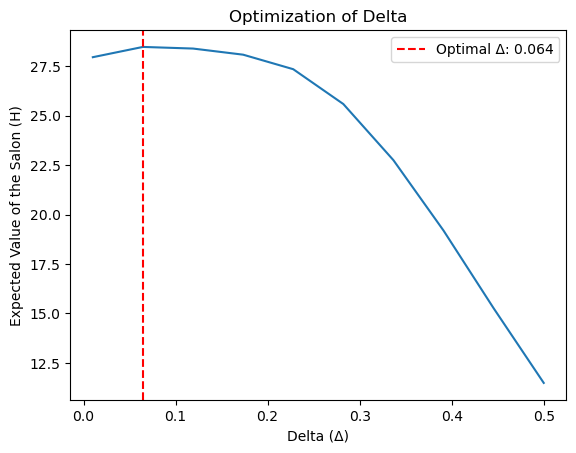

Optimal Delta (Δ): 0.06444444444444444
Maximum Expected Value of the Salon (H): 28.480739651741715


In [23]:
# plotting the results
plt.plot(delta_vec, H_vec)
plt.xlabel("Delta (Δ)")
plt.ylabel("Expected Value of the Salon (H)")
plt.title("Optimization of Delta")
plt.axvline(x=optimal_delta, color='r', linestyle='--', label=f"Optimal Δ: {optimal_delta:.3f}")
plt.legend()
plt.show()

print("Optimal Delta (Δ):", optimal_delta)
print("Maximum Expected Value of the Salon (H):", max_H)

With the optimal policy, we again note a higher profitability,  $H_{optimal-policy}=28.48>H_{policy}=28.43>H_{original}=27.75$.


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



When a negative demand shock hits, labour is decreased, and when a positive demand shock hits, labour increases. Since we assume that it is costlier to fire people than hire people, we model an alternative policy where the effect on adjustment costs from demand shocks is assymetrical. Thus the shocks will have an absolute smaller effect when the demand shock is positive than negative.

In [24]:
# function to calculate h(epsilon_0, epsilon_1, ..., epsilon_119)
def calculate_h_iota(epsilon, iota):
    kappa_t_minus_1 = 1  # initial demand shock
    l_t_minus_1 = 0  # initial number of employees
    h_value = 0  # accumulator for h function

    # we loop over the time period T = 120
    for t in range(120):
        epsilon_t = epsilon[t]
        log_kappa_t = rho * np.log(kappa_t_minus_1) + epsilon_t
        kappa_t = np.exp(log_kappa_t)

        # calculating l_t based on the policy
        l_t = ((1 - eta) * kappa_t / w) ** (1 / eta)

        if kappa_t >= 0:
            iota = 0.01*kappa_t**0.5
        else:
            iota = 0.01*-kappa_t

        # calculating the h function value for this period
        h_value += R ** (-t) * (kappa_t * l_t ** (1 - eta) - w * l_t - (l_t != l_t_minus_1) * iota)

        # updating the variables for the next period
        kappa_t_minus_1 = kappa_t
        l_t_minus_1 = l_t

    return h_value

H = np.mean([calculate_h_iota(epsilon, iota) for epsilon in epsilon_list])
print("Expected value of the salon (H) with the policy =", H)


Expected value of the salon (H) with the policy = 27.77141325851136


We note that this assymetrical policy did not increase profitability compared to the policy implemented in question 3 and 4. It is however slightly more profitable than the case in question 2:
$$H_{optimal-policy}=28.48>H_{policy}=28.43>H_{asymetrical-policy}=27.77>H_{original}=27.75$$

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [25]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.
As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

The optimal solution is: [3.14263714e-10 5.51301154e-10]
And the objective value is: 0.0


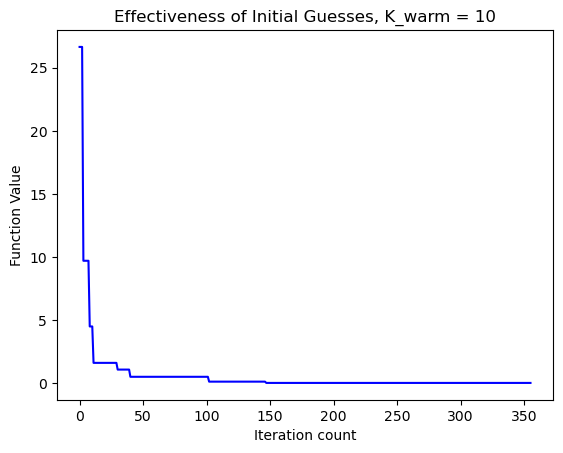

In [26]:
# defining the refined global optimizer with multi-start
def multi_start():

    # step 1
    x_min, x_max = [-600,600] # bounds
    tau = 1e-8 # tolerance
    np.random.seed(1998)

    # step 2
    K_warm = 10 # warm-up iterations
    K = 1000 # maximum nb. of iterations

    # step 3
    # A
    x_opt = np.random.uniform(x_min, x_max, size=2) # initial best solution
    f_opt = griewank(x_opt) # function evaluated at best solution
    f_opt_store1 = [f_opt]  # storing best solutions

    for k in range(K):
        x = np.random.uniform(x_min, x_max, size=2) # generate random solution

        # B
        if k < K_warm:
            x_k0 = x
        else:
            # C: calculate chi
            Chi_k = 0.50 * 2 / (1 + np.exp((k - K_warm) / 100)) 
            # D: refine initial guess
            x_k0 = Chi_k * x + (1 - Chi_k) * x_opt 

        # E: optimize with x_k0 as initial guess
        result = optimize.minimize(griewank, x_k0, method='BFGS', tol=tau)
        x_k_star = result.x # optimized solution

        # F: updating best solution (x_opt) if necessary
        f_k_star = griewank(x_k_star)
        if f_k_star < f_opt:
            x_opt = x_k_star
            f_opt = f_k_star

        # G: check tolerance
        if f_opt < tau:
            break

        f_opt_store1.append(f_opt)  # storing best objective for each iteration

    # step 4 
    return x_opt, f_opt_store1 # return result and stored history

#printing results
result, f_opt_store1 = multi_start()
print("The optimal solution is:", result)
print("And the objective value is:", griewank(result))

# plotting the best objective value as a function of iteration counter
iterations = range(len(f_opt_store1))
plt.plot(iterations, f_opt_store1, c='blue')
plt.xlabel("Iteration count")
plt.ylabel("Function Value")
plt.title("Effectiveness of Initial Guesses, K_warm = 10")
plt.show()

Implementing the refined global optimizer with multistart indicates that the best objective value is zero after about 150 iterations (when using the chosen seed). 

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

The optimal solution is: [-2.78820218e-09 -9.20510420e-09]
And the objective value is: 0.0


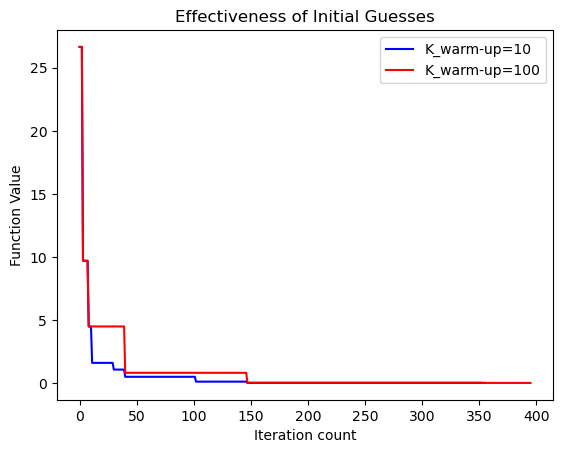

In [27]:
# defining the refined global optimizer with multi-start
def multi_start_new():

    # step 1
    x_min, x_max = [-600,600] # bounds
    tau = 1e-8 # tolerance
    np.random.seed(1998)

    # step 2
    K_warm = 100 # warm-up iterations
    K = 1000 # maximum nb. of iterations

    # step 3
    # A
    x_opt = np.random.uniform(x_min, x_max, size=2) # initial best solution
    f_opt = griewank(x_opt) # function evaluated at best solution
    f_opt_store2 = [f_opt]  # storing best solutions

    for k in range(K):
        x = np.random.uniform(x_min, x_max, size=2) # generate random solution

        # B
        if k < K_warm:
            x_k0 = x
        else:
            # C: calculate chi
            Chi_k = 0.50 * 2 / (1 + np.exp((k - K_warm) / 100)) 
            # D: refine initial guess
            x_k0 = Chi_k * x + (1 - Chi_k) * x_opt 

        # E: optimize with x_k0 as initial guess
        result = optimize.minimize(griewank, x_k0, method='BFGS', tol=tau)
        x_k_star = result.x # optimized solution

        # F: updating best solution (x_opt) if necessary
        f_k_star = griewank(x_k_star)
        if f_k_star < f_opt:
            x_opt = x_k_star
            f_opt = f_k_star

        # G: check tolerance
        if f_opt < tau:
            break

        f_opt_store2.append(f_opt)  # storing best objective for each iteration

    # step 4 
    return x_opt, f_opt_store2 # return result and stored history

#printing results
result, f_opt_store2 = multi_start_new()
print("The optimal solution is:", result)
print("And the objective value is:", griewank(result))

# plotting the function value as a function of iteration counter
iterations1 = range(len(f_opt_store1))
iterations2 = range(len(f_opt_store2))

plt.plot(iterations1, f_opt_store1, c='blue', label='K_warm-up=10')
plt.plot(iterations2, f_opt_store2, c='red', label='K_warm-up=100')

plt.xlabel("Iteration count")
plt.ylabel("Function Value")
plt.title("Effectiveness of Initial Guesses")
plt.legend()
plt.show()

We see that setting a higher value of $\underline{K}$ makes the convergence slower compared to the first case where $\underline{K} = 10$. 

The griewank function is multimodal and has many local and global optima, making it challenging for optimisation algorithms. The more warm-up iterations are used, the larger a portion of the search space is explored by the algorithm before looking further into the more promising regions. However this also increases the time spent and lowers the speed of convergence. This is the exploration vs. exploitation trade-off. 